In [1]:
import pandas as pd
import numpy as np
import csv, os
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from utils import language_map, get_avg_token_freq, get_n_low_freq_words, get_avg_word_length_with_punct

geco_data = pd.read_csv('../data/geco/data_with_ling_feats.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)

In [2]:
# with open('../data/geco/preprocessed/preprocessed_geco_sentence_level.tsv',  'r', encoding='utf8') as infile:
#     with open('../data/geco/sents.txt', 'w', encoding='utf8') as outfile:
#         lines = infile.readlines()
#         for i, line in enumerate(lines):
#             if i > 0:
#                 elements = line.strip('\n').split('\t')
#                 sent = elements[3]
#                 outfile.write(sent + '\n')

Add frequencies to dataframe:

In [3]:
geco_data['avg_token_freq'] = get_avg_token_freq(geco_data['text'].tolist(), 'English')
geco_data['n_low_freq_words'] = get_n_low_freq_words(geco_data['text'].tolist(), 'English')
geco_data['avg_word_length'] = get_avg_word_length_with_punct(geco_data['text'].tolist())

Scale eye-tracking features to fall in the range 0-100:

In [4]:
from sklearn.preprocessing import MinMaxScaler

def scale(feature_values):

    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(feature_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)

    return flat_scaled_feature_values

def inverse_transform(true_values, predicted_values):
    
    scaler = MinMaxScaler(feature_range=(0,100))

    # reshape 1D array to 2D
    reshaped_feature_list = np.array(true_values).reshape(-1, 1)

    # scale feature values between 0 and 100
    scaled_feature_values = scaler.fit_transform(reshaped_feature_list)

    # flatten the 2D array to 1D
    flat_scaled_feature_values = np.ravel(scaled_feature_values)
    
    # inverse transform
    inversed_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1,1))
    
    # flatten the 2D array to 1D
    flat_inversed_values = np.ravel(inversed_values)
    
    return flat_inversed_values

def add_scaled_columns(df):
    
    df['scaled_fpd'] = scale(df['first_pass_dur'].tolist())
    df['scaled_fxc'] = scale(df['fix_count'].tolist())
    df['scaled_tfd'] = scale(df['tot_fix_dur'].tolist())
    df['scaled_rd'] = scale(df['tot_regr_from_dur'].tolist())
    
    return df

In [5]:
#add columns with predictions

def add_preds(df, language):

    fpd_preds=[]
    fxc_preds=[]
    tfd_preds=[]
    rd_preds=[]

    with open(f'../results/preds_normal/preds_eval-meco-{language}_4.tsv', 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            items = line.split('\t')
            task = items[0]
            pred = float(items[1].lstrip('[').rstrip(']'))
            label = items[2]
            if task == 'scaled_first_pass_dur':
                fpd_preds.append(pred)
            elif task == 'scaled_fix_count':
                fxc_preds.append(pred)
            elif task == 'scaled_tot_fix_dur':
                tfd_preds.append(pred)
            elif task == 'scaled_tot_regr_from_dur':
                rd_preds.append(pred)

#     df['fpd_pred'] = inverse_transform(df['first_pass_dur'], fpd_preds)
#     df['fxc_pred'] = inverse_transform(df['fix_count'], fxc_preds)
#     df['tfd_pred'] = inverse_transform(df['tot_fix_dur'], tfd_preds)
#     df['rd_pred'] = inverse_transform(df['tot_regr_from_dur'], rd_preds)

    df['fpd_pred'] = fpd_preds
    df['fxc_pred'] = fxc_preds
    df['tfd_pred'] = tfd_preds
    df['rd_pred'] = rd_preds
    
    return df

def add_preds_scrambled(df, language):

    fpd_preds=[]
    fxc_preds=[]
    tfd_preds=[]
    rd_preds=[]

    with open(f'../results/eye-movement-prediction/preds_scrambled/preds_eval-meco-scrambled-{language}_4.tsv', 'r') as infile:
        lines = infile.readlines()
        for line in lines:
            items = line.split('\t')
            task = items[0]
            pred = float(items[1].lstrip('[').rstrip(']'))
            label = items[2]
            if task == 'scaled_first_pass_dur':
                fpd_preds.append(pred)
            elif task == 'scaled_fix_count':
                fxc_preds.append(pred)
            elif task == 'scaled_tot_fix_dur':
                tfd_preds.append(pred)
            elif task == 'scaled_tot_regr_from_dur':
                rd_preds.append(pred)

#     df['fpd_pred'] = inverse_transform(df['first_pass_dur'], fpd_preds)
#     df['fxc_pred'] = inverse_transform(df['fix_count'], fxc_preds)
#     df['tfd_pred'] = inverse_transform(df['tot_fix_dur'], tfd_preds)
#     df['rd_pred'] = inverse_transform(df['tot_regr_from_dur'], rd_preds)

    df['fpd_pred_scrambled'] = fpd_preds
    df['fxc_pred_scrambled'] = fxc_preds
    df['tfd_pred_scrambled'] = tfd_preds
    df['rd_pred_scrambled'] = rd_preds
    
    return df


Read MECO data:

In [6]:
def get_meco_df(language):
    
    path = f'../data/meco/files_per_language/{language}/test.tsv'
    
    if os.path.exists(path):
        df = pd.read_csv(f'../data/meco/files_per_language/{language}/test.tsv', sep='\t', encoding='utf8')
        df['dataset'] = len(df) * [f'{language}']
        
        #add frequency information
        if language != 'Estonian' and language != 'Korean':
            df['avg_token_freq'] = get_avg_token_freq(df['text'], language)
            df['n_low_freq_words'] = get_n_low_freq_words(df['text'], language)
            df['avg_word_length'] = get_avg_word_length_with_punct(df['text'].tolist())

        df = df.rename(columns={'sent.nwords': 'token_count'})
        df = add_preds(df, language)
    
    return df

Plot eye-tracking metrics:

<Figure size 432x288 with 0 Axes>

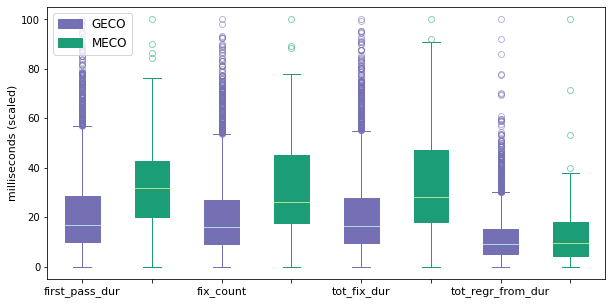

In [7]:
fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

et_metrics = ['first_pass_dur', 'fix_count', 'tot_fix_dur', 'tot_regr_from_dur']
meco_english = get_meco_df('English')

results_list=[]
labels=[]
for metric in et_metrics:
    results_list.append(geco_data[f'scaled_{metric}'].tolist())
    results_list.append(meco_english[f'scaled_{metric}'].tolist())
    labels.extend([metric, ''])

# rectangular box plot
bplot1 = ax1.boxplot(results_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)

# fill with colors
colors = ['#7570b3', '#1b9e77'] * len(et_metrics)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['lightblue', '#b2df8a'] * len(et_metrics)
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3', '#1b9e77', '#1b9e77'] * len(et_metrics)
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(list(range(1, 9)), fontsize=11, horizontalalignment='center')
plt.ylabel("milliseconds (scaled)", fontsize=11)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['GECO', 'MECO'], loc='upper left', prop={'size': 12})

<Figure size 432x288 with 0 Axes>

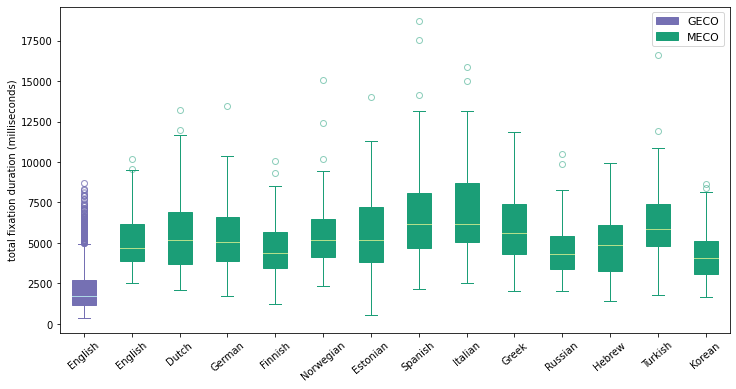

In [8]:
fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

languages = ['English', 'Dutch', 'German', 'Finnish', 'Norwegian', 'Estonian', 'Spanish', 'Italian', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Korean']

#tfd_list = [geco_dutch['tot_fix_dur'].tolist(), geco_english['tot_fix_dur'].tolist()]
tfd_list = [geco_data['tot_fix_dur'].tolist()]
for lang in languages:
    df = get_meco_df(lang)
    tfd_list.append(df['tot_fix_dur'].tolist())

    
labels = ['English', 'English', 'Dutch', 'German', 'Finnish', 'Norwegian', 'Estonian', 'Spanish',  'Italian', 'Greek', 'Russian', 'Hebrew', 'Turkish', 'Korean']

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['lightblue'] + ['#b2df8a'] * len(languages) * 2
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['#7570b3', '#7570b3'] + ['#1b9e77'] * len(languages) * 2
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(rotation=40)
plt.ylabel("total fixation duration (milliseconds)")
plt.legend([bplot1["boxes"][0], bplot1["boxes"][2]], ['GECO', 'MECO'], loc='upper right', prop={'size': 11})
        
#plt.savefig('tfd-distribution-all.pdf', dpi=300, bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

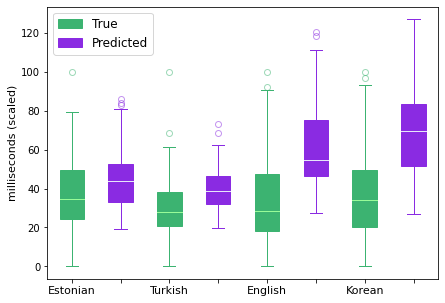

In [9]:
fig = plt.figure()
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7,5))

languages = ['Estonian', 'Turkish', 'English', 'Korean']

tfd_list=[]
labels=[]
for language in languages:
    df = get_meco_df(language)
    tfd_list.append(df['scaled_tot_fix_dur'].tolist())
    tfd_list.append(df['tfd_pred'].tolist())
    labels.extend([language, ''])

# rectangular box plot
bplot1 = ax1.boxplot(tfd_list,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels,
                     showfliers=True)  # will be used to label x-ticks

# fill with colors
colors = ['mediumseagreen', 'blueviolet'] * len(languages)
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set_markeredgecolor(color)
    patch.set_alpha(0.5)
    
colors = ['palegreen', 'lavender'] * len(languages)
for patch, color in zip(bplot1['medians'], colors):
     patch.set_color(color)
        
colors = ['mediumseagreen', 'mediumseagreen', 'blueviolet', 'blueviolet'] * len(languages)
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)

for patch, color in zip(bplot1['caps'], colors):
    patch.set_color(color)
    
plt.xticks(list(range(1, 9)), fontsize=11, horizontalalignment='center')
plt.ylabel("milliseconds (scaled)", fontsize=11)
plt.legend([bplot1["boxes"][0], bplot1["boxes"][1]], ['True', 'Predicted'], loc='upper left', prop={'size': 12})
#plt.title('Total Fixation Duration', fontsize=14)

#plt.savefig('tfd-true-vs-pred.pdf', dpi=300, bbox_inches='tight')

In [10]:
meco_english = get_meco_df('English')

target_feats_meco = ['scaled_first_pass_dur', 'scaled_fix_count', 'scaled_tot_fix_dur', 'scaled_tot_regr_from_dur',
                'fpd_pred', 'fxc_pred', 'tfd_pred', 'rd_pred',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping_meco = {'scaled_first_pass_dur': 'first-pass duration',
                'scaled_fix_count': 'fixation count',
                'scaled_tot_fix_dur': 'total fixation duration',
                'scaled_tot_regr_from_dur': 'regression duration',
                 'fpd_pred': 'first-pass duration (pred)',
                 'fxc_pred': 'fixation count (pred)',
                 'tfd_pred': 'total fixation duration (pred)',
                 'rd_pred': 'regression duration (pred)',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats_meco:
    meco_english = meco_english.rename(columns={f'{f}': name_mapping_meco[f]})

In [11]:
geco_data = pd.read_csv('../data/geco/data_with_ling_feats.tsv', sep='\t', encoding='utf8', quoting=csv.QUOTE_NONE)
geco_data = add_scaled_columns(geco_data)

target_feats_geco = ['scaled_first_pass_dur', 'scaled_fix_count', 'scaled_tot_fix_dur', 'scaled_tot_regr_from_dur',
                'token_count', 'avg_word_length',             
                'lexical_density',                                                  
                'avg_max_depth', 'avg_links_len', 'max_links_len', 'verbal_head_per_sent', 
                'avg_token_freq', 'n_low_freq_words']                                    

name_mapping_geco = {'scaled_first_pass_dur': 'first-pass duration',
                'scaled_fix_count': 'fixation count',
                'scaled_tot_fix_dur': 'total fixation duration',
                'scaled_tot_regr_from_dur': 'regression duration',
                'token_count': 'sentence length (tokens)',
                'avg_word_length': 'avg. word length (characters)',
                'lexical_density': 'lexical density',
                'avg_max_depth': 'parse tree depth',
                'avg_links_len': 'avg. dependency link length',
                'max_links_len': 'max. dependency link length',
                'verbal_head_per_sent': 'number of verbal heads',
                'avg_token_freq': 'avg. word frequency',
                'n_low_freq_words': 'number of low frequency words'}

for f in target_feats_geco:
    geco_data[f] = pd.to_numeric(geco_data[f], downcast="float")
    geco_data = geco_data.rename(columns={f'{f}': name_mapping_geco[f]})

In [12]:
order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'number of low frequency words',
         'avg. dependency link length',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

geco_corr = geco_data[name_mapping_geco.values()].corr(method='spearman')
geco_corr = geco_corr.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration'], axis=0)
geco_corr = geco_corr[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']].sort_values(by=['first-pass duration'],ascending=False)

geco_corr = geco_corr.reindex(order)
geco_corr

,first-pass duration,total fixation duration,fixation count,regression duration
sentence length (tokens),0.949602,0.923221,0.934937,0.661267
max. dependency link length,0.792826,0.774587,0.781735,0.549564
parse tree depth,0.775851,0.758539,0.768119,0.546459
number of verbal heads,0.714754,0.692585,0.699209,0.498819
number of low frequency words,0.589984,0.597990,0.595219,0.407622
avg. dependency link length,0.611626,0.600106,0.603737,0.433681
avg. word length (characters),0.147191,0.171380,0.172423,0.082497
lexical density,0.111994,0.127750,0.122927,0.074156
avg. word frequency,-0.143830,-0.171156,-0.163674,-0.090819


In [13]:
order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'number of low frequency words',
         'avg. dependency link length',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

corr_true = meco_english[name_mapping_meco.values()].corr(method='spearman')
corr_true = corr_true.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

corr_true = corr_true[['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration']]
corr_true = corr_true.reindex(order)
corr_true

,first-pass duration,total fixation duration,fixation count,regression duration
sentence length (tokens),0.666863,0.840359,0.865512,0.162989
max. dependency link length,0.368615,0.447464,0.462985,0.072665
parse tree depth,0.422112,0.611440,0.633583,0.193564
number of verbal heads,0.422554,0.508099,0.522222,0.075301
number of low frequency words,0.420602,0.553950,0.543803,0.178676
avg. dependency link length,0.280860,0.261679,0.270648,0.027082
avg. word length (characters),0.156028,0.013897,0.016983,-0.015568
lexical density,0.068195,-0.109593,-0.117378,-0.155432
avg. word frequency,-0.054756,0.085591,0.096970,0.065513


In [14]:
order = ['sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'number of low frequency words',
         'avg. dependency link length',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

corr_pred = meco_english[name_mapping_meco.values()].corr(method='spearman')
corr_pred = corr_pred.drop(['first-pass duration', 'total fixation duration', 'fixation count', 'regression duration',
                  'first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)'], 
                   axis=0)

corr_pred = corr_pred[['first-pass duration (pred)', 'total fixation duration (pred)', 'fixation count (pred)', 'regression duration (pred)']].sort_values(by=['first-pass duration (pred)'],ascending=False)
corr_pred = corr_pred.reindex(order)
corr_pred

,first-pass duration (pred),total fixation duration (pred),fixation count (pred),regression duration (pred)
sentence length (tokens),0.937146,0.936657,0.934168,0.859619
max. dependency link length,0.586233,0.581268,0.581286,0.520295
parse tree depth,0.654119,0.666166,0.666077,0.604137
number of verbal heads,0.558567,0.555094,0.553386,0.502406
number of low frequency words,0.581984,0.573211,0.585318,0.496489
avg. dependency link length,0.369441,0.359191,0.359668,0.287125
avg. word length (characters),0.058097,0.069248,0.063008,0.070342
lexical density,-0.098304,-0.089126,-0.095779,-0.139634
avg. word frequency,0.083377,0.079963,0.073630,0.104836


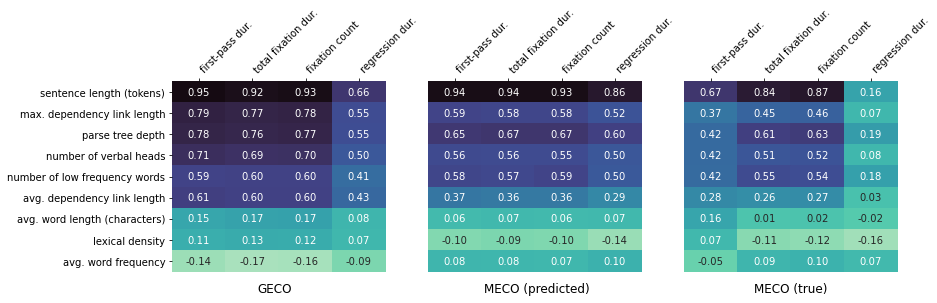

In [15]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(13,3.5))

sns.heatmap(geco_corr,
            ax=ax1,
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f')
        
sns.heatmap(corr_pred,
            ax=ax2, 
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f',
            yticklabels=False)

sns.heatmap(corr_true,
            ax=ax3, 
            vmax=1,
            vmin=-0.3,
            cmap='mako_r',
            cbar=False,
            annot=True,
            linewidths=0,
            fmt='.2f',
            yticklabels=False)

x_axis_labels = ['first-pass dur.', 'total fixation dur.', 'fixation count', 'regression dur.']

for ax in ax1, ax2, ax3:
    ax.set_xticklabels(x_axis_labels, rotation=45, horizontalalignment='left')
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    
ax1.text(1.6, 10, 'GECO', fontsize=12)
ax2.text(1.05, 10, 'MECO (predicted)', fontsize=12)
ax3.text(1.3, 10, 'MECO (true)', fontsize=12)

plt.savefig('correlations.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [37]:
import scipy

df = meco_english

target_feats = ['first-pass duration', 'fixation count', 'total fixation duration', 'regression duration',
         'sentence length (tokens)',
         'max. dependency link length',
         'parse tree depth',
         'number of verbal heads',
         'avg. dependency link length',
         'number of low frequency words',
         'avg. word length (characters)',
         'lexical density',
         'avg. word frequency']

for et in target_feats[:4]:
    for ling in target_feats[4:]:
        if scipy.stats.spearmanr(df[et], df[ling])[1] > 0.01:
            print(f"correlation between {et} and {ling}:", scipy.stats.spearmanr(df[et], df[ling])[0])
            print("p={:.8f}".format(scipy.stats.spearmanr(df[et], df[ling])[1]))
            print()

correlation between first-pass duration and avg. word length (characters): 0.15602832500734054
p=0.12302323

correlation between first-pass duration and lexical density: 0.06819534000979541
p=0.50241234

correlation between first-pass duration and avg. word frequency: -0.054755720470006174
p=0.59037175

correlation between fixation count and avg. word length (characters): 0.01698259068810326
p=0.86749544

correlation between fixation count and lexical density: -0.11737842078462474
p=0.24724262

correlation between fixation count and avg. word frequency: 0.09696969696969698
p=0.33966101

correlation between total fixation duration and avg. word length (characters): 0.013896533603848515
p=0.89141077

correlation between total fixation duration and lexical density: -0.1095928016057226
p=0.28021241

correlation between total fixation duration and avg. word frequency: 0.08559059987631415
p=0.39959362

correlation between regression duration and sentence length (tokens): 0.16298919585937885


In [17]:
def make_true_pred_df(lang, trial, sentnum, text, true, pred, length):
# avg_word_length, avg_dep_length, max_dep_length, parse_depth, avg_word_freq, n_low_freq_words, lex_dens, verbal_heads):
    df = pd.DataFrame()
    df['lang'] = lang
    df['trialid'] = trial
    df['sentnum'] = sentnum
    df['sentence'] = text
    df['true_value'] = true
    df['pred_value'] = pred
    df['sent_length'] = length
#     df['avg_word_length'] = avg_word_length
#     df['avg_dep_length'] = avg_dep_length
#     df['max_dep_length'] = max_dep_length
#     df['parse_depth'] = parse_depth
#     df['avg_word_freq'] = avg_word_freq
#     df['n_low_freq_words'] = n_low_freq_words
#     df['lex_dens'] = lex_dens
#     df['verbal_heads'] = verbal_heads
    return df

In [18]:
import matplotlib.pyplot as plt

def get_true_pred_df(meco_df):
    
    return make_true_pred_df(meco_df['lang'], 
                    meco_df['trialid'], 
                    meco_df['sentnum'], 
                    meco_df['text'], 
                    meco_df['scaled_tot_fix_dur'], 
                    meco_df['tfd_pred'],
                    meco_df['token_count'])
#                    meco_df['avg_word_length'])
#                     meco_df['avg_links_len'],
#                     meco_df['max_links_len'],
#                     meco_df['avg_max_depth'],
#                     meco_df['avg_word_freq'],
#                     meco_df['n_low_freq_words'])

Text(0.03, 0.5, 'milliseconds (scaled)')

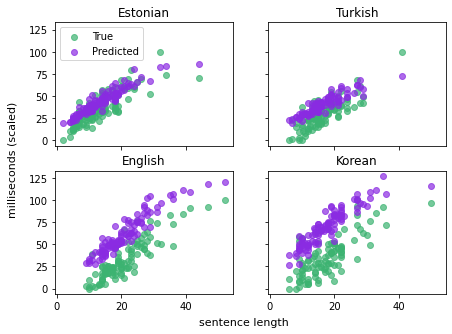

In [19]:
languages = ['Estonian', 'Turkish', 'English','Korean']
true_pred_df_1 = get_true_pred_df(get_meco_df(languages[0]))
true_pred_df_2 = get_true_pred_df(get_meco_df(languages[1]))
true_pred_df_3 = get_true_pred_df(get_meco_df(languages[2]))
true_pred_df_4 = get_true_pred_df(get_meco_df(languages[3]))

colors = ['blueviolet', 'mediumseagreen']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(7,5))

x = true_pred_df_1['sent_length']
y_true = true_pred_df_1['true_value']
y_pred = true_pred_df_1['pred_value']
ax1.scatter(x,y_true,alpha=0.7,c=colors[1])
ax1.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax1.set_title(languages[0])

x = true_pred_df_2['sent_length']
y_true = true_pred_df_2['true_value']
y_pred = true_pred_df_2['pred_value']
ax2.scatter(x,y_true,alpha=0.7,c=colors[1])
ax2.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax2.set_title(languages[1])

x = true_pred_df_3['sent_length']
y_true = true_pred_df_3['true_value']
y_pred = true_pred_df_3['pred_value']
ax3.scatter(x,y_true,alpha=0.7,c=colors[1])
ax3.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax3.set_title(languages[2])

x = true_pred_df_4['sent_length']
y_true = true_pred_df_4['true_value']
y_pred = true_pred_df_4['pred_value']
ax4.scatter(x,y_true,alpha=0.7,c=colors[1])
ax4.scatter(x,y_pred,alpha=0.7,c=colors[0])
ax4.set_title(languages[3])
ax1.legend(['True', 'Predicted'], loc='upper left', fontsize=10)

fig.text(0.5, 0.04, 'sentence length', ha='center', fontsize=11)
fig.text(0.03, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)

#plt.savefig('preds_4_languages.pdf',dpi=300, bbox_inches='tight')

Text(0.06, 0.5, 'milliseconds (scaled)')

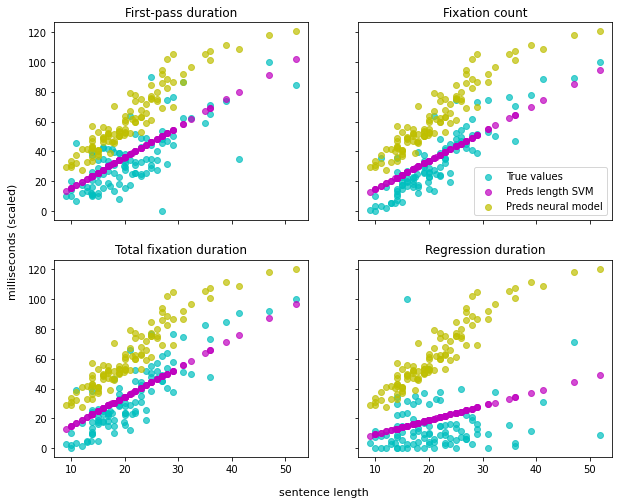

In [20]:
# 4 eye-tracking metrics vs. 1 SVM

svm_type = 'length'
language = 'English'
preds_neural = get_true_pred_df(get_meco_df(language))
x = preds_neural['sent_length']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))

title_dict = {'first_pass_dur': 'First-pass duration',
              'fix_count': 'Fixation count',
              'tot_fix_dur': 'Total fixation duration',
              'tot_regr_from_dur': 'Regression duration'}

for et_metric, ax in zip(['first_pass_dur', 'fix_count', 'tot_fix_dur', 'tot_regr_from_dur'], [ax1, ax2, ax3, ax4]):
    preds_svm = pd.read_csv(f'../results/preds_svm/preds-{svm_type}-svm-scaled_{et_metric}-English-4.tsv', sep='\t', names=['et-feature', 'pred_value', 'true_value'])
    y_true = preds_svm['true_value']
    y_svm = preds_svm['pred_value']
    y_neural = preds_neural['pred_value']
    ax.scatter(x,y_true,alpha=0.7,c='c')
    ax.scatter(x,y_svm,alpha=0.7,c='m')
    ax.scatter(x,y_neural,alpha=0.7,c='y')
    ax.set_title(title_dict[et_metric])

ax2.legend(['True values', f'Preds {svm_type} SVM', 'Preds neural model'], loc='lower right')

fig.text(0.5, 0.06, 'sentence length', ha='center', fontsize=11)
fig.text(0.06, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)

Text(0.06, 0.5, 'milliseconds (scaled)')

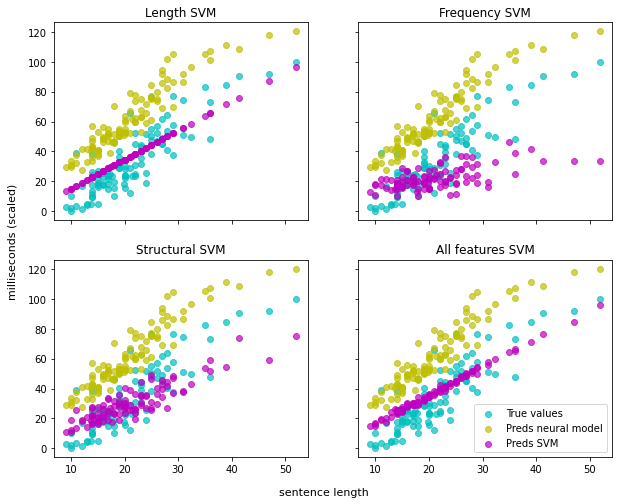

In [21]:
# 4 SVMs vs 1 eye-tracking metric

et_metric = 'tot_fix_dur'
language = 'English'
preds_neural = get_true_pred_df(get_meco_df(language))
x = preds_neural['sent_length']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))

title_dict = {'length': 'Length SVM',
              'frequency': 'Frequency SVM',
              'linguistic': 'Structural SVM',
              'all': 'All features SVM'}

for svm_type, ax in zip(['length', 'frequency', 'linguistic', 'all'], [ax1, ax2, ax3, ax4]):
    preds_svm = pd.read_csv(f'../results/preds_svm/preds-{svm_type}-svm-scaled_{et_metric}-English-4.tsv', sep='\t', names=['et-feature', 'pred_value', 'true_value'])
    y_true = preds_svm['true_value']
    y_neural = preds_neural['pred_value']
    y_svm = preds_svm['pred_value']
    ax.scatter(x,y_true,alpha=0.7,c='c')
    ax.scatter(x,y_neural,alpha=0.7,c='y')
    ax.scatter(x,y_svm,alpha=0.7,c='m')
    ax.set_title(title_dict[svm_type])

ax4.legend(['True values', f'Preds neural model', 'Preds SVM'], loc='lower right')
fig.text(0.5, 0.06, 'sentence length', ha='center', fontsize=11)
fig.text(0.06, 0.5, 'milliseconds (scaled)', va='center', rotation='vertical',fontsize=11)